Security and Privacy in ML

Instructor: Dr. Sadeghzadeh

HW06

Student Name:Mahdi Saieedi

Student ID: 401207254

# Differential privacy for numeric queries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml # need sklearn >= 0.22

In [7]:
import sklearn
print(sklearn.__version__)

1.2.2


Below we provide a helper function to draw bar plots from pandas Series.





In [3]:
def bar_plot_pandas(series1, series2=None, label1="Series 1", label2="Series 2", title=""):
    '''
    Draws a bar plot of one Pandas Series, or two pandas Series with the same index

    Parameters
    ----------
    series1 : Series of float
        First input
    series2 : Series of float, optional
        Second input (with same index)
    label1 : string, optional
        Label for the first series
    label2 : string, optional
        Label for the second series
    title : string, optional
        Plot title
    '''
    if not isinstance(series1, pd.Series):
        raise ValueError("series1 must be a pandas Series")

    # Check if series2 is provided and ensure it is a pandas Series
    if series2 is not None and not isinstance(series2, pd.Series):
        raise ValueError("series2 must be a pandas Series if provided")

    # Check if series2 is provided and has the same index as series1
    if series2 is not None and not series1.index.equals(series2.index):
        raise ValueError("series1 and series2 must have the same index")

    # Create the plot
    if series2 is None:
        ax = series1.plot.bar()
        ax.legend([label1])
    else:
        concat_series = pd.DataFrame({label1: series1, label2: series2})
        ax = concat_series.plot.bar()

    # Set title and labels
    ax.set_title(title)
    ax.set_xlabel("Index")
    ax.set_ylabel("Value")

    # Display the plot
    plt.show()
    # if series2 is None:
    #     series1.plot.bar()
    #     plt.legend([label1])
    # else:
    #     concat_series = pd.DataFrame({label1: series1, label2: series2}).reset_index()
    #     concat_series.plot.bar(x="index", y=[label1, label2], xlabel="", title=title)

In [4]:
data1 = pd.Series([1, 2, 3], index=['a', 'b', 'c'])
data2 = pd.Series([4, 5, 6], index=['a', 'b', 'c'])

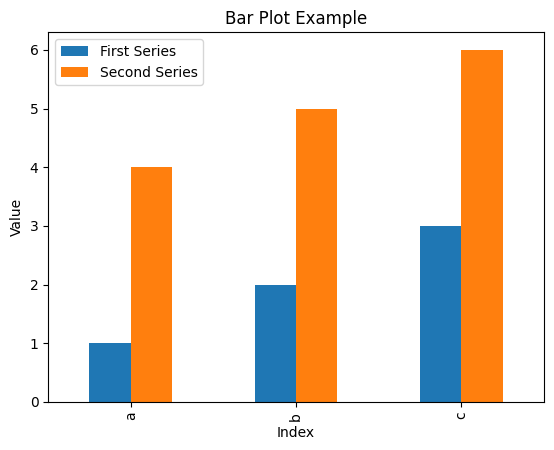

In [5]:
bar_plot_pandas(data1, data2, label1="First Series", label2="Second Series", title="Bar Plot Example")

## Dataset

We will be working with a dataset from the US Census (also known as the Adult dataset). You can read about the dataset [here](https://archive.ics.uci.edu/ml/datasets/census+income).

The following line loads the dataset from [OpenML](https://www.openml.org/) with the `fetch_openml` method of `sklearn`. The option `as_frame=True` (**requires sklearn version >= 0.22**) loads the dataset in `pandas DataFrame` format: this keeps the attributes in their original form and will be more convenient to work with. If you prefer working with a numpy array (not recommended), set `as_frame=False`.

In [8]:
dataset_handle = fetch_openml(name='adult', version=2, as_frame=True)
dataset = dataset_handle.frame

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Take a look at the dataset, in particular the number of rows (individuals), the number of columns (attributes) and what they represent.

In [9]:
n, d = dataset.shape
print(n, d)
dataset.head(10)

48842 15


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25.0,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,<=50K
1,38.0,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K
2,28.0,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,>50K
3,44.0,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States,>50K
4,18.0,NaN,103497.0,Some-college,10.0,Never-married,NaN,Own-child,White,Female,0.0,0.0,30.0,United-States,<=50K
5,34.0,Private,198693.0,10th,6.0,Never-married,Other-service,Not-in-family,White,Male,0.0,0.0,30.0,United-States,<=50K
6,29.0,NaN,227026.0,HS-grad,9.0,Never-married,NaN,Unmarried,Black,Male,0.0,0.0,40.0,United-States,<=50K
7,63.0,Self-emp-not-inc,104626.0,Prof-school,15.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,3103.0,0.0,32.0,United-States,>50K
8,24.0,Private,369667.0,Some-college,10.0,Never-married,Other-service,Unmarried,White,Female,0.0,0.0,40.0,United-States,<=50K
9,55.0,Private,104996.0,7th-8th,4.0,Married-civ-spouse,Craft-repair,Husband,White,Male,0.0,0.0,10.0,United-States,<=50K


## Question 1 (non-private queries) [15 pts]

Implement a function for each of these types of queries (without privacy) and test them on the dataset:
- **Simple count queries**: it takes as input a dataset (`DataFrame`), a categorical attribute (e.g., `"sex"`) and a value (e.g., `"Male"`), and returns how many rows in the dataset have the prescribed attribute value.
- **Averaging queries**: it takes as input a dataset and a numeric attribute (e.g., `"age"`), and returns the average value of this attribute in the dataset.
- **Histogram queries**: it takes as input a dataset and a categorical attribute (e.g., `"sex"`), and returns the histogram of counts for this attribute in the dataset (i.e., for each possible value of the attribute, how many rows have this value).

Reminder: for a DataFrame `df`, we can access the column corresponding to an attribute `attr` by `df[attr]`. The method `value_counts()` allows to build a histogram of a column. To plot a pandas Series `s` as a histogram, you can use `s.plot.bar()`.

Note: You can use the function `bar_plot_pandas` provided in the preamble to draw a bar plot of a pandas Series, which is useful to show histograms.

In [10]:
def count_query(df, attribute, value):
    '''
    Parameters
    ----------
    df : DataFrame
        Dataset
    attribute : string
        Name of an attribute with categorical values
    value : string or int
        Value of attribute to count

    Returns
    -------
    count : int
        The number of records with `attribute=value` in dataset `df`
    '''
    count = df[df[attribute] == value].shape[0]
    return count

In [11]:
def average_query(df, attribute):
    '''
    Parameters
    ----------
    df : DataFrame
        Dataset
    attribute : string
        Name of an attribute with numeric values

    Returns
    -------
    average : float
        The average value of `attribute` in dataset `df`
    '''
    average = df[attribute].mean()
    return average

In [12]:
def histogram_query(df, attribute):
    '''
    Parameters
    ----------
    df : DataFrame
        Dataset
    attribute : string
        Name of an attribute with categorical values

    Returns
    -------
    histogram : array or Series of int
        The histogram of `attribute`, i.e., the number of times each value of `attribute` appears in `df`
    '''
    histogram = df[attribute].value_counts()
    return histogram

## Question 2 (Laplace mechanism) [15 pts]

Implement the Laplace mechanism, i.e., a function which takes as input a (non-private) query output, the query's $\ell_1$ sensitivity, the desired value of $\epsilon$ and a random seed (for reproducibility), and returns a $\epsilon$-differentially private estimate of the query. To draw Laplace noise, check `np.random.laplace`. The function should work with queries that output a scalar (like simple count and averaging queries), as well as those that output a vector (like histogram queries).

In [42]:
def laplace_mechanism(q, s1, eps, random_state=None):
    '''
    Parameters
    ----------
    q : float or array/Series of float
        The non-private output of the query
    s1 : float
        The L1 sensitivity of the query
    eps : float
        Parameter epsilon of differential privacy
    random_state : int, optional (default=None)
        Random seed

    Returns
    -------
    private_q : float or array/Series of float
        An eps-DP evaluation of the query
    '''
    if eps == 0:
      return q
    rng = np.random.RandomState(random_state)
    scale = s1 / eps

    if hasattr(q, 'shape'): # query output is multi-dimensional
      noise = rng.laplace(0, scale, q.shape)
    else: # query output is a scalar
      noise = rng.laplace(0, scale)

    private_q = q + noise
    return private_q



## Question 3 (Laplace mechanism on count queries) [10pts]

We would like to use the Laplace mechanism to:
- privately count the number of males in the dataset
- generate a private histogram of the `"workclass"` attribute

What is the sensitivity of the query in each case?

Run the Laplace mechanism with different values of $\epsilon$ and compute the $\ell_1$-error with respect to the true (non-private) output to see the effect on the utility and compare with the formal error bound seen in the lecture. Recall that the mechanism is random, so unless you fix the seed you will get a different result at each execution. Visually compare the private and non-private histograms using the function `bar_plot_pandas` provided at the beginning of the notebook.

Note: you may round the outputs of the private mechanism to make them integers if you like. This can be considered as post-processing and thus preserves DP (see Bonus Question 5 to go further on this aspect).

In [14]:
def l1_error(a, b):
    '''
    Parameters
    ----------
    a : float or array/Series of float
        First input
    b : float or array/Series of float
        Second input

    Returns
    -------
    l1_error : float
        The L1 distance between `a` and `b`: ||a-b||_1
    '''
    return np.sum(np.abs(a - b))



In [15]:
# list of (query,sensitivity) tuples to loop over
# queries =
queries = [
    (lambda df: count_query(df, 'sex', 'Male'), 1),
    (lambda df: histogram_query(df, 'workclass'), 1)
]

In [16]:
# Different epsilon values to test
epsilons = [0.1, 1.0]

In [18]:
# # Access the data and target
# data = dataset.data
# target = dataset.target
# # Combine data and target into a single DataFrame
# data['target'] = target

In [19]:
results = []
for eps in epsilons:
  for query, sensitivity in queries:
    true_result = query(dataset)
    private_result = laplace_mechanism(true_result, sensitivity, eps, random_state=42)
    error = l1_error(true_result, private_result)
    results.append((eps, true_result, private_result, error))

    print(f"Epsilon: {eps}")
    print(f"True result:\n{true_result}")
    print(f"Private result:\n{private_result}")
    print(f"L1 error: {error}\n")


Epsilon: 0.1
True result:
32650
Private result:
32647.110908252256
L1 error: 2.889091747743805

Epsilon: 0.1
True result:
workclass
Private             33906
Self-emp-not-inc     3862
Local-gov            3136
State-gov            1981
Self-emp-inc         1695
Federal-gov          1432
Without-pay            21
Never-worked           10
Name: count, dtype: int64
Private result:
workclass
Private             33903.110908
Self-emp-not-inc     3885.169743
Local-gov            3142.235985
State-gov            1983.197954
Self-emp-inc         1683.353674
Federal-gov          1420.352128
Without-pay            -0.527245
Never-worked           23.180837
Name: count, dtype: float64
L1 error: 92.49505358249019

Epsilon: 1.0
True result:
32650
Private result:
32649.711090825225
L1 error: 0.2889091747747443

Epsilon: 1.0
True result:
workclass
Private             33906
Self-emp-not-inc     3862
Local-gov            3136
State-gov            1981
Self-emp-inc         1695
Federal-gov          143

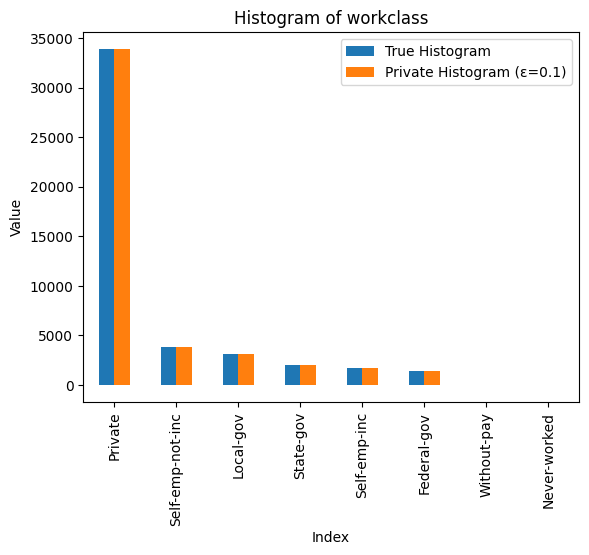

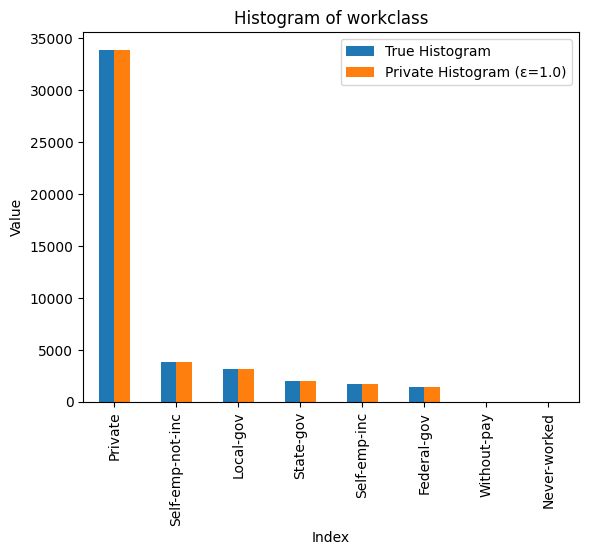

In [20]:
# Example usage of bar_plot_pandas for histograms
attribute = 'workclass'
true_histogram = histogram_query(dataset, attribute)
for eps in epsilons:
    private_histogram = laplace_mechanism(true_histogram, 1, eps, random_state=42)
    bar_plot_pandas(true_histogram, private_histogram, label1="True Histogram", label2=f"Private Histogram (ε={eps})", title=f"Histogram of {attribute}")


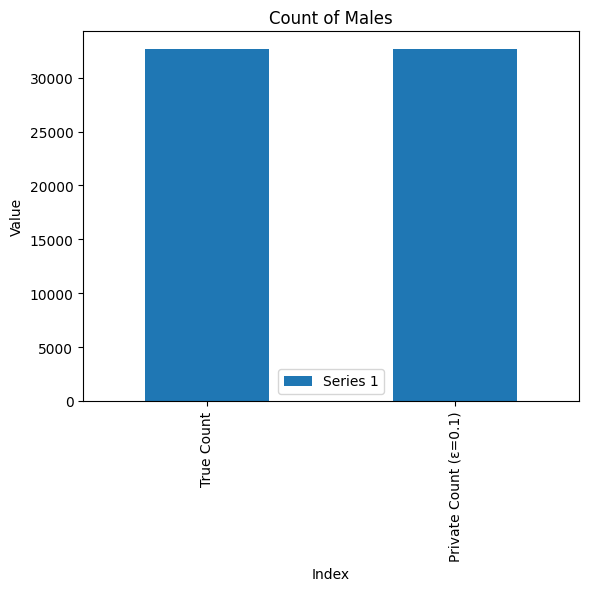

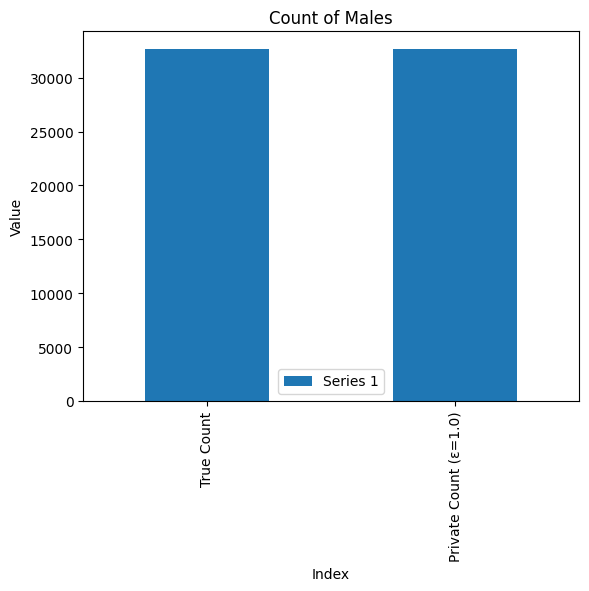

In [21]:
# Plot for count_query
true_count = count_query(dataset, 'sex', 'Male')
for eps in epsilons:
    private_count = laplace_mechanism(true_count, 1, eps, random_state=42)
    count_series = pd.Series([true_count, private_count], index=["True Count", f"Private Count (ε={eps})"])
    bar_plot_pandas(count_series, title="Count of Males")

## Question 4 (contingency tables and the "paradox" of parallel composition) [10 pts]

We can go beyond histograms and build contingency tables across two (or even more) variables. Implement a function for such queries using `crosstab` from pandas, and use the Laplace mechanism to privately find out how people in the dataset break down according to the combination of `'gender'` and `'marital-status'`. You may need to adapt your implementation of Laplace to work with k-way tables (e.g., by using the method `applymap` together with a function that adds 1D Laplace noise).

Pushing this reasoning further, it may seem that there is a paradox because parallel composition gets us more information "for free" (e.g., we can build a k-way table over a large number of attributes that could ultimately reveal very precise information about individuals in the dataset, without increasing the privacy loss). This contradicts the principle that asking more things should cost something. Explain why there is in fact no paradox and what is the cost that one pays in this case (if needed, you can see what happens when privately releasing contingency tables across many columns).

In [22]:
def table_query(df, row_attr_list, col_attr_list):
    '''
    Parameters
    ----------
    df : DataFrame
        Dataset
    row_attr_list : list
        List of attributes
    col_attr_list : list
        List of attributes

    Returns
    -------
    cross_table : DataFrame
        Cross tabulation (contingency table) of `df` according to `row_attr_list` and `col_attr_list`
    '''
    cross_table = pd.crosstab(index=[df[attr] for attr in row_attr_list],
                              columns=[df[attr] for attr in col_attr_list])
    return cross_table


In [23]:
def add_laplace_noise_to_table(cross_table, sensitivity, epsilon, random_state=None):
    noise_function = np.vectorize(lambda x: laplace_mechanism(x, sensitivity, epsilon, random_state))
    noisy_table = cross_table.applymap(noise_function)
    return noisy_table

In [24]:
# Define attributes for the contingency table
row_attributes = ['sex']
col_attributes = ['marital-status']


In [25]:
# Compute the contingency table
true_table = table_query(dataset, row_attributes, col_attributes)
print("True contingency table:\n", true_table)

True contingency table:
 marital-status  Divorced  Married-AF-spouse  Married-civ-spouse  \
sex                                                               
Female              4001                 25                2480   
Male                2632                 12               19899   

marital-status  Married-spouse-absent  Never-married  Separated  Widowed  
sex                                                                       
Female                            304           7218        931     1233  
Male                              324           8899        599      285  


In [26]:
# Apply Laplace mechanism to the contingency table
epsilon = 1.0
sensitivity = 1  # Sensitivity of the count query is 1
private_table = add_laplace_noise_to_table(true_table, sensitivity, epsilon, random_state=42)
print("Private contingency table (ε = 1.0):\n", private_table)

Private contingency table (ε = 1.0):
 marital-status     Divorced  Married-AF-spouse  Married-civ-spouse  \
sex                                                                  
Female          4000.711091          24.711091         2479.711091   
Male            2631.711091          11.711091        19898.711091   

marital-status  Married-spouse-absent  Never-married   Separated      Widowed  
sex                                                                            
Female                     303.711091    7217.711091  930.711091  1232.711091  
Male                       323.711091    8898.711091  598.711091   284.711091  


## Question 5 (Laplace mechanism on average queries) [15pts]

We would like to use the Laplace mechanism to privately estimate the average age of people in the dataset. We assume that the number of people in the dataset is public.

1. Propose and implement simple practical strategies to compute or estimate the sensitivity of this query in the following two scenarios, and discuss the merits and/or drawbacks of your proposals:
  - You are the trusted curator: you have access to the raw dataset and would like to release an estimate of the average age of people in the dataset with differential privacy guarantees.

#######################################################################################################
Strategy to Compute Sensitivity:
As a trusted curator with access to the raw dataset, you can directly compute the sensitivity by using the range of the age attribute. The sensitivity S  for the average age query is given by:

S = (max(age) - min(age))/n

where n is the number of people in the dataset.

#######################################################################################################
  - You are an external data analyst: you do not have access to the raw dataset but only to an API to send queries. You have to convince the trusted curator that the proposed sensitivity is safe.

#######################################################################################################
As an external data analyst, you can estimate the sensitivity by assuming plausible bounds for the age attribute, such as the typical minimum and maximum ages. For example, you might assume that the ages range from 0 to 100. The sensitivity S can then be estimated as:


S = (100- 0 )/n

where n is the number of people in the dataset.

#######################################################################################################


2. Suggest some ideas regarding how we could change a bit the query to get a simple and safe bound on sensitivity, at the expense of possibly introducing some bias in the output. Implement the proposed solution. Hint: the method `clip` from pandas might be useful here.

#######################################################################################################

To ensure a simple and safe bound on sensitivity, we can clip the ages to a predefined range before computing the average. This introduces some bias but ensures the sensitivity is within a known range.

#######################################################################################################


In [35]:
def compute_sensitivity_trusted(df, attribute):
    max_value = df[attribute].max()
    min_value = df[attribute].min()
    n = len(df)
    sensitivity = (max_value - min_value) / n
    return sensitivity

In [30]:
# Example usage for trusted curator
sensitivity = compute_sensitivity_trusted(dataset, 'age')
print(f"Sensitivity (Trusted Curator): {sensitivity}")

Sensitivity (Trusted Curator): 0.0014946152901191597


In [34]:
def estimate_sensitivity_external(n, min_age=0, max_age=100):
    sensitivity = (max_age - min_age) / n
    return sensitivity

In [28]:
# Example usage for external data analyst
n = len(dataset)
estimated_sensitivity = estimate_sensitivity_external(n)
print(f"Estimated Sensitivity (External Analyst): {estimated_sensitivity}")

Estimated Sensitivity (External Analyst): 0.0020474182056426844


In [32]:
def compute_average_age_with_clipping(df, attribute, clip_min, clip_max, epsilon):
    clipped_ages = df[attribute].clip(lower=clip_min, upper=clip_max)
    true_average = clipped_ages.mean()
    n = len(df)
    sensitivity = (clip_max - clip_min) / n
    private_average = laplace_mechanism(true_average, sensitivity, epsilon)
    return private_average

In [33]:
# Example usage for clipped average age
clip_min = 0
clip_max = 100
epsilon = 1.0
private_average_age = compute_average_age_with_clipping(dataset, 'age', clip_min, clip_max, epsilon)
print(f"Differentially Private Average Age with Clipping: {private_average_age}")


Differentially Private Average Age with Clipping: 38.643623618295194


## Question 6 (average over a subset) [15 pts]

We would now like to compute the average age of divorced people. How can we use the Laplace mechanism to privately answer this query? Implement your solution.

To compute the differentially private average age of divorced people, we can use the Laplace mechanism. Here are the steps to achieve this:


1- Filter the Dataset

2- Clip the Ages

3-Compute the True Average Age

4-Compute the Sensitivity

5-Add Laplace Noise

In [36]:
def compute_average_age_divorced(df, clip_min, clip_max, epsilon, random_state=None):
    divorced_df = df[df['marital-status'] == 'Divorced']
    # Clip the ages to the specified range
    clipped_ages = divorced_df['age'].clip(lower=clip_min, upper=clip_max)
    # Compute the true average age
    true_average = clipped_ages.mean()
    # Compute the sensitivity
    n = len(divorced_df)
    sensitivity = (clip_max - clip_min) / n
    # Apply the Laplace mechanism
    private_average = laplace_mechanism(true_average, sensitivity, epsilon, random_state)
    return private_average

In [37]:
clip_min = 0
clip_max = 100
epsilon = 1.0
random_state = 42

# Compute the differentially private average age of divorced people
private_average_age_divorced = compute_average_age_divorced(dataset, clip_min, clip_max, epsilon, random_state)
print(f"Differentially Private Average Age of Divorced People: {private_average_age_divorced}")

Differentially Private Average Age of Divorced People: 43.154848346528354


## Question 7 (Gaussian mechanism and comparison with Laplace) [20 pts]

Implement the Gaussian mechanism (to draw Gaussian noise, check `np.random.normal`). Make an experimental comparison with the Laplace mechanism by plotting the privacy-utility trade-off for a 1D query of your choice. For the Gaussian mechanism, study the influence of $\delta$.

In [38]:
def gaussian_mechanism(q, s2, eps, delta, random_state=None):
    '''
    Parameters
    ----------
    q : float or array/Series of float
        The non-private output of the query
    s2 : float
        The L2 sensitivity of the query
    eps : float
        Parameter epsilon of differential privacy
    delta : float
        Parameter delta of differential privacy
    random_state : int, optional (default=None)
        Random seed

    Returns
    -------
    private_q : float or array/Series of float
        An (eps,delta)-DP evaluation of the query
    '''

    rng = np.random.RandomState(random_state)
    scale = np.sqrt(2 * np.log(1.25 / delta)) * s2 / eps

    if hasattr(q, 'shape'): # query output is multi-dimensional
        noise = rng.normal(0, scale, q.shape)
    else: # query output is a scalar
        noise = rng.normal(0, scale)
    private_q = q + noise
    return private_q

In [40]:
def compute_average_age_divorced2(df, clip_min, clip_max, epsilon, mechanism='laplace', delta=None, random_state=None):
    divorced_df = df[df['marital-status'] == 'Divorced']
    clipped_ages = divorced_df['age'].clip(lower=clip_min, upper=clip_max)
    true_average = clipped_ages.mean()
    n = len(divorced_df)
    sensitivity = (clip_max - clip_min) / n
    if mechanism == 'laplace':
        private_average = laplace_mechanism(true_average, sensitivity, epsilon, random_state)
    elif mechanism == 'gaussian':
        if delta is None:
            raise ValueError("delta must be provided for the Gaussian mechanism")
        private_average = gaussian_mechanism(true_average, sensitivity, epsilon, delta, random_state)
    else:
        raise ValueError("Unknown mechanism: {}".format(mechanism))
    return private_average

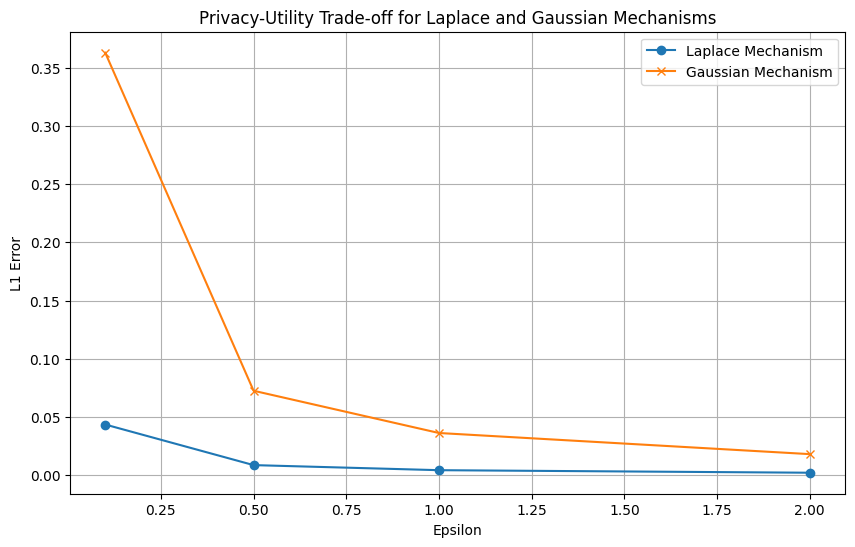

In [43]:
# Parameters for the experiment
clip_min = 0
clip_max = 100
epsilons = [0.1, 0.5, 1.0, 2.0]
delta = 1e-5
random_state = 42

# Compute the true average age for comparison
true_average_age = compute_average_age_divorced2(dataset, clip_min, clip_max, epsilon=0, mechanism='laplace')

laplace_errors = []
gaussian_errors = []

for epsilon in epsilons:
    laplace_avg = compute_average_age_divorced2(dataset, clip_min, clip_max, epsilon, mechanism='laplace', random_state=random_state)
    gaussian_avg = compute_average_age_divorced2(dataset, clip_min, clip_max, epsilon, mechanism='gaussian', delta=delta, random_state=random_state)

    laplace_errors.append(np.abs(true_average_age - laplace_avg))
    gaussian_errors.append(np.abs(true_average_age - gaussian_avg))

plt.figure(figsize=(10, 6))
plt.plot(epsilons, laplace_errors, marker='o', label='Laplace Mechanism')
plt.plot(epsilons, gaussian_errors, marker='x', label='Gaussian Mechanism')
plt.xlabel('Epsilon')
plt.ylabel('L1 Error')
plt.title('Privacy-Utility Trade-off for Laplace and Gaussian Mechanisms')
plt.legend()
plt.grid(True)
plt.show()

In [46]:
def compute_average_age_divorced3(df, clip_min, clip_max):
    divorced_df = df[df['marital-status'] == 'Divorced']
    clipped_ages = divorced_df['age'].clip(lower=clip_min, upper=clip_max)
    true_average = clipped_ages.mean()
    n = len(divorced_df)
    sensitivity = (clip_max - clip_min) / n
    return true_average, sensitivity, n


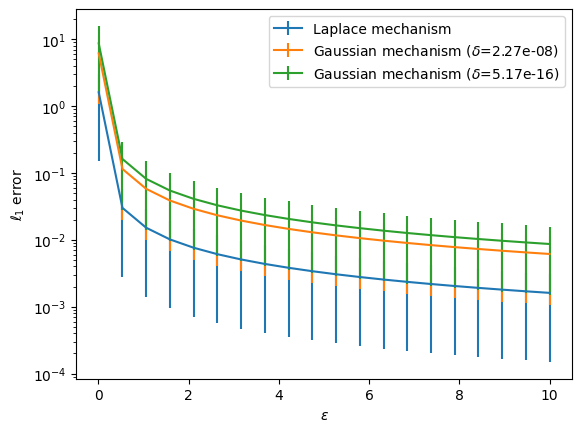

In [47]:

# Compute true average and sensitivity
clip_min = 0
clip_max = 100
true_average, sensitivity, n = compute_average_age_divorced3(dataset, clip_min, clip_max)

eps_list = np.linspace(0.01, 10.0, num=20)
delta1 = 1. / n**2
delta2 = 1. / n**4
n_runs = 50

error = np.zeros((len(eps_list), 3, n_runs))

for i, eps in enumerate(eps_list):
    for r in range(n_runs):
       # Laplace mechanism
        laplace_result = laplace_mechanism(true_average, sensitivity, eps, random_state=r)
        error[i, 0, r] = np.abs(true_average - laplace_result)

        # Gaussian mechanism with delta1
        gaussian_result1 = gaussian_mechanism(true_average, sensitivity, eps, delta1, random_state=r)
        error[i, 1, r] = np.abs(true_average - gaussian_result1)

        # Gaussian mechanism with delta2
        gaussian_result2 = gaussian_mechanism(true_average, sensitivity, eps, delta2, random_state=r)
        error[i, 2, r] = np.abs(true_average - gaussian_result2)



fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.errorbar(eps_list, error[:, 0, :].mean(axis=1), error[:, 0, :].std(axis=1), label='Laplace mechanism')
ax.errorbar(eps_list, error[:, 1, :].mean(axis=1), error[:, 1, :].std(axis=1),
            label='Gaussian mechanism ($\delta$=' + "{:.2e}".format(delta1) + ')')
ax.errorbar(eps_list, error[:, 2, :].mean(axis=1), error[:, 2, :].std(axis=1),
            label='Gaussian mechanism ($\delta$=' + "{:.2e}".format(delta2) + ')')
plt.xlabel("$\epsilon$")
plt.ylabel("$\ell_1$ error")
ax.set_yscale('log')
ax.legend()